In [38]:
import os
from skimage import io
import matplotlib.patches as patches
import cv2
import altair as alt
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

## Project

In this project from Kaggle, I am creating a convolutional neural network (CNN) to classify whether the objects in the scan are metastatic or not. These pictures are taken from pathology scans and the Kaggle dataset is a subset of the full data at https://github.com/basveeling/pcam. A tumor is classified as positive for cancer (metastatic) if there is a patch 32x32 pixel patch of the image that contains at least one pizel of tumor tissue.

There are 220,025 training images as well as corresponding data that labels each photo in a binary manner as being metastatic. Then, there are 57,458 images that are utilized as the test set for the project. Hence, I will train my CNN on the provided training data and then make a production for each class of the test data using my model. These predictions will then be uploaded to Kaggle and tested for their accuracy.

## Data

I imported the training dataframe from a csv and then converted the label column to a string type. Further, I added '.tif' to the end of each file id so that the images could be read in. Further, I shuffled the data in the training df, so that my model would not train on the ordering of the data, I also utilized a random state so that my data was reproducible. Further, I creted a test dataframe of the test images. Lastly, I set a batch size of 64 that I will use in image generation and in modeling.

In [50]:
#input training labels (file and label)
train_df = pd.read_csv('train_labels.csv')
#putting labels as string for image generator
train_df['label'] = train_df['label'].astype(str)
train_df['id'] += '.tif'
# train['id'] = train['id'].apply(lambda x: 'train/' + x)
#creating random state to apply shuffling to data
train_df = shuffle(train_df, random_state = 42)


#sample_submission
# sample = pd.read_csv('sample_submission.csv')

#creating test data frame to import data, creates id col with name of file
test = pd.DataFrame({'id':os.listdir('test')})

#setting batch size for entire project
batch_size = 64


## EDA
Our first EDA comes from Kaggle as we are told there are no duplicate files in the data. Then, I wanted to start by checking for null values. To do this, I looked at df.info() and saw we had no non-null values. I further showed the df.describe() just to confirm there were no duplicates.

I then wanted to check to see if our data was unbalanced among the classes. Thus, I created a bar chart for the counts of each class and we got that there were approximately 57% of class 0 and 43% of class 1. This indicates a slight imbalance, but it is not enough that corrective action is needed. 

Then, I showed 9 random images from the training data (from the above shuffle) just to give an idea of what the photos represent. However, when I was implementing this, I found there was a file that contained an image which was nearly entirely black and clearly would not provide value to the task at hand. Hence, I removed this file from training and I also showed this image to explain why I removed it.



In [41]:
#EDA
#check n and number of null's
print(train_df.info())

#simple stats for 'label' column
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220024 entries, 11942 to 121958
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220024 non-null  object
 1   label   220024 non-null  object
dtypes: object(2)
memory usage: 13.1+ MB
None
                                                  id   label
count                                         220024  220024
unique                                        220024       2
top     fcd55f03496afb4b11598d9c2231e86da318e723.tif       0
freq                                               1  130907


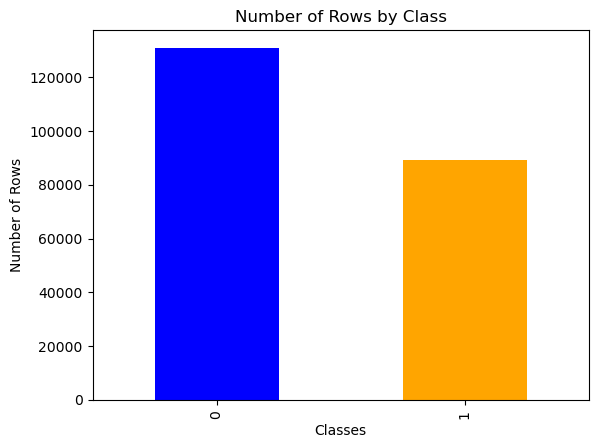

In [33]:
#chart for number for class
train_df['label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Number of Rows by Class')
plt.xlabel('Classes')
plt.ylabel('Number of Rows')
plt.show()

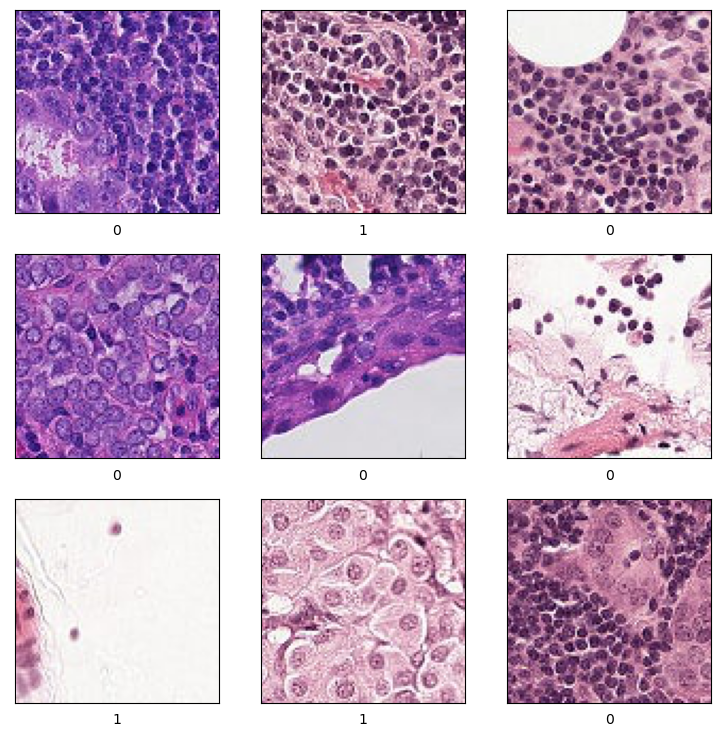

In [35]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i, axis in enumerate(ax.flat):
    file = str('train/' + str(train_df['id'].iloc[i]))
    image = io.imread(file)
    axis.imshow(image)
    axis.set(xticks=[], yticks=[], xlabel = train_df.label[i]);

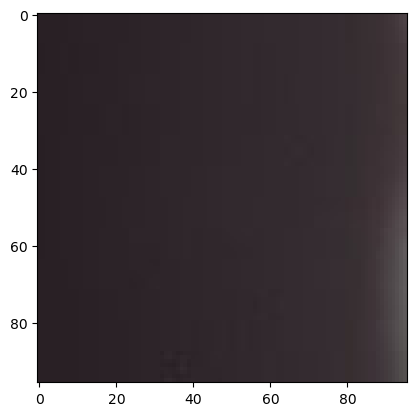

In [42]:
#Removing image that is just black image
bad_file = 'd293308913e4a40cebb809d986aa9add65a76bfa.tif'
plt.imshow(io.imread('train/' + bad_file))

#Removing this file from dataset even when randomly shuffled 
train_df.drop(train_df[train_df['id'] == bad_file].index, inplace = True)

## Preparing Data to Model

I began by splitting the training into 80% training and 20% validation, so that the model would have something by which to validate its results.

Then, I utilized ImageDataGenerator from keras and rescaled the data by dividing each value on the RGB scale by 255 and then set the generator for a 80/20 training split. This function allowed me to grab the images that were found in the 'id' column in both the training and validation df's. In these generators, I also shuffled the data again, normalized by the standard deviation of the features, and set the target size from (96,96) to (64, 64) for optimal modeling. With our images in their corresponding training and validation sets, we are ready to model.

In [51]:
#split this into training and validation for model
train, valid = train_test_split(train_df, test_size = 0.2)


#creating method to generate training and validation images
#creates validation set of 0.2 size of training data and scales pixels
generator_data = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.2
)


#getting image generator based upon labels in train df
train_generator = generator_data.flow_from_dataframe(
    dataframe = train,
    directory = 'train',
    x_col = 'id',
    y_col = 'label',
    shuffle = True,
    featurewise_std_normalization = True,
    class_mode = 'binary',
    batch_size = batch_size,
    random_state = 42,
    target_size = (64, 64)
)

#getting image generator based upon lables in valid df
valid_generator = generator_data.flow_from_dataframe(
    dataframe = valid,
    directory = 'train',
    x_col = 'id',
    y_col = 'label', 
    shuffle = True,
    featurewise_std_normalization = True,
    class_mode = 'binary',
    batch_size = batch_size,
    random_state = 42,
    target_size = (64, 64)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [59]:
#CNN Model


model = Sequential([
    Conv2D(32, kernel_size = (3,3), input_shape = (64,64,3), activation = 'relu'),
    Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])
model.summary()


#sgd optimizer
opt = Adam(
    lr = 0.0001,
    amsgrad=True
)

#learning rate scheduler for improved speed
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

#callback to run learning rate scheduler
callback = LearningRateScheduler(scheduler)

#early stopping
early_stopping = EarlyStopping(patience=2)

#ROC 
ROC = AUC()

#model compiler
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', ROC])

#fitting the model
model.fit(
    train_generator,
    validation_data = valid_generator,
    batch_size = batch_size,
    epochs = 10,
    callbacks = [callback, early_stopping],
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_31 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 64)       

/Users/sam/miniconda3/envs/data_science/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-02-14 21:45:20.492655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2750/2751 [============================>.] - ETA: 0s - loss: 0.4016 - accuracy: 0.8230 - auc_5: 0.8934

2023-02-14 21:46:47.201979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2751/2751 [==============================] - 102s 37ms/step - loss: 0.4016 - accuracy: 0.8230 - auc_5: 0.8934 - val_loss: 0.4601 - val_accuracy: 0.8138 - val_auc_5: 0.9099 - lr: 1.0000e-04
Epoch 2/10
2751/2751 [==============================] - 100s 36ms/step - loss: 0.3347 - accuracy: 0.8566 - auc_5: 0.9277 - val_loss: 0.2997 - val_accuracy: 0.8731 - val_auc_5: 0.9434 - lr: 9.0484e-05
Epoch 3/10
2751/2751 [==============================] - 100s 36ms/step - loss: 0.2936 - accuracy: 0.8764 - auc_5: 0.9446 - val_loss: 0.3757 - val_accuracy: 0.8409 - val_auc_5: 0.9298 - lr: 8.1873e-05
Epoch 4/10
2751/2751 [==============================] - 118s 43ms/step - loss: 0.2723 - accuracy: 0.8870 - auc_5: 0.9523 - val_loss: 0.2799 - val_accuracy: 0.8910 - val_auc_5: 0.9517 - lr: 7.4082e-05
Epoch 5/10
2751/2751 [==============================] - 117s 43ms/step - loss: 0.2573 - accuracy: 0.8943 - auc_5: 0.9575 - val_loss: 0.2668 - val_accuracy: 0.8913 - val_auc_5: 0.9565 - lr: 6.7032e-05
Epoch 6/10


## Prediction and Submission

Once the model had been trained, we used it to generate class predictions for the test images. I began to do this by using another image generator. Here, we again rescaled, we utilized a image size of (64,64), and we did not shuffle here as this would provide no advantage. Once the generator was complete, the model made its predictions. 

Then, we matched the prediction to the format of the sample submission by changing the id's and by marking a label as 1 if the prediction was >= 0.5 and 0 else. Finally, I connected to the Kaggle API and uploaded my data through this.

In [60]:
data_generator_test = ImageDataGenerator(
    rescale = 1./255.,
)

#creating sequence of image generator
test_generator = data_generator_test.flow_from_dataframe(
    dataframe = test,
    directory ='test',
    x_col = 'id', 
    y_col = None,
    target_size = (64, 64),         
    batch_size = 1,
    shuffle = False,
    class_mode = None
)


#prediction
predict = model.predict(
    x = test_generator
)

Found 57458 validated image filenames.
   46/57458 [..............................] - ETA: 2:09 

2023-02-14 22:03:19.858464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57458/57458 [==============================] - 116s 2ms/step


In [61]:
# predict = np.transpose(predict)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predict))
submission_df.head()
submission_df.to_csv('sub.csv', index=False)
import kaggle
! chmod 600 /Users/sam/.kaggle/kaggle.json
! kaggle competitions submit -c histopathologic-cancer-detection -f sub.csv -m "CNN 2/14/11:06"

100%|███████████████████████████████████████| 2.36M/2.36M [00:03<00:00, 646kB/s]
Successfully submitted to Histopathologic Cancer Detection